Unsupervised learning - Clustering

In [23]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np  
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('ddos_dataset.csv', low_memory=False)
X = pd.read_csv('pca_dataframe.csv', low_memory=False).to_numpy()
y = df['label']
n_y = len(y.unique()) #number of different labels

Hierarchical Clustering

In [3]:
parameters = {'ward', 'complete', 'average', 'single'}
labels = []

for param in parameters:
    aggC = AgglomerativeClustering(n_clusters=n_y, linkage=param)
    labels.append(aggC.fit_predict(X))

plt.figure(figsize=(6, 3.5))
plt.plot([p for p in parameters], [silhouette_score(X, label) for label in labels])
plt.title('Agglomerative Clustering silhouette score based on linkage parameter changes')
plt.grid()
plt.show()

: 

With hierarchical clustering the silhouette score reach 0.9 that is the highest one, but at the same time the rand index score and adjusted rand index score have the lowest values (more or less 0, remember that RI and ARI are supervised learning metric for cluster evaluation and they represent "accuracy" in respect of the label of the dataset) in comparison with the other clustering algorithm evaluated in the study. 

KMeans

Best number of clusters: 13 with corresponding silhouette score: 0.5424126718933323


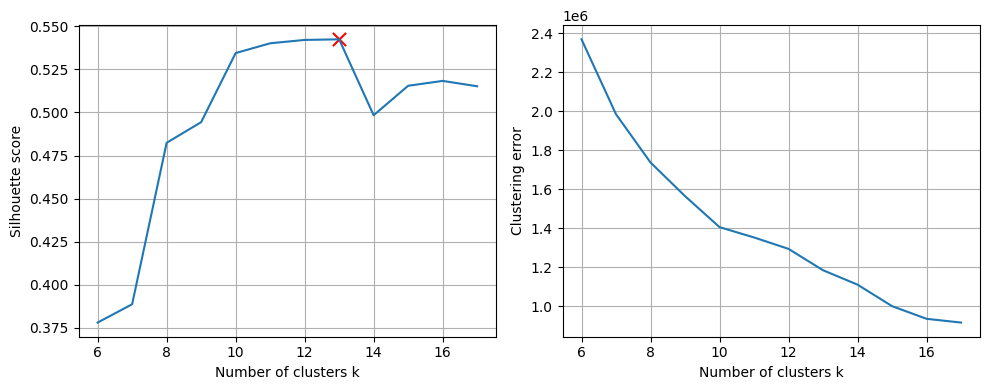

In [48]:
kmeans_labels = []
sh_scores = []
cl_scores = []

for k in range (int(0.5*n_y), int(1.5*n_y)):
    results = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42).fit(X)
    kmeans_labels.append(results.labels_)
    sh_scores.append(silhouette_score(X, results.labels_))
    cl_scores.append(results.inertia_)

n_clusters = [n for n in range(int(0.5*n_y), int(1.5*n_y))]
best_sh = np.max(sh_scores)
best_n = n_clusters[np.argmax(sh_scores)]
print(f'Best number of clusters: {best_n} with corresponding silhouette score: {best_sh}')

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(n_clusters, sh_scores)
axs[0].scatter(best_n, best_sh, color='r', marker='x', s=90)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Silhouette score")
axs[0].grid()

axs[1].plot(n_clusters, cl_scores)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Clustering error")
axs[1].grid()

plt.tight_layout()
plt.show()

In [25]:
kmeans = KMeans(n_clusters=13, init='k-means++', n_init='auto', random_state=42)
result = kmeans.fit(X)
labels = result.labels_
print(f'Silhouette score for KMeans cluster algorithm is {silhouette_score(X, labels)}')
print(f'Clustering error: {result.inertia_}')

Silhouette score for KMeans cluster algorithm is 0.5424126718933323
Clustering error: 1183811.8713118306


Hyperparameter tuning

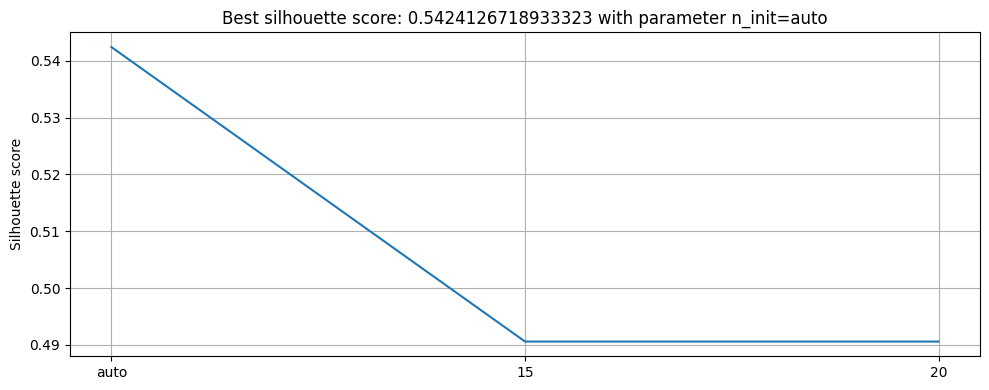

In [50]:
n_init = ['auto', 15, 20]
sh_scores = []

for n in n_init:
    results = KMeans(n_clusters=13, init='k-means++', random_state=42, n_init=n).fit(X)
    labels = results.labels_
    sh_scores.append((silhouette_score(X, labels)))


plt.figure(figsize=(10, 4))

plt.plot(n_init, sh_scores)
plt.title(f'Best silhouette score: {np.max(sh_scores)} with parameter n_init={n_init[np.argmax(sh_scores)]}')
plt.ylabel('Silhouette score')
plt.grid()

plt.tight_layout()
plt.show()

Number of cluster selection: we evaluate the proper number of clusters on the silhouette score in a validation computing the silhouette score for differents number cluster of parameters for each clustering algorithm chosen

Gaussian Mixture

Best number of clusters: 17 with corresponding silhouette score: 0.39576278288596006


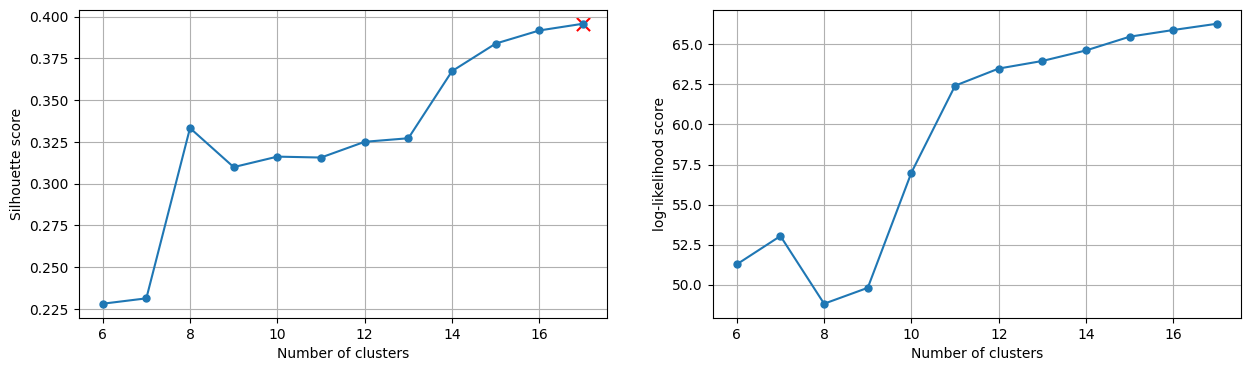

In [43]:
n_cluster = []
sh_scores = []
log_score = []
for n in range(int(n_y / 2), int(1.5 * n_y)):
    gmm = GaussianMixture(n_components=n, random_state=42).fit(X)
    labels = gmm.predict(X)
    n_cluster.append(n)
    sh_scores.append(silhouette_score(X, labels))
    log_score.append(gmm.score(X))

best_sh = np.max(sh_scores)
best_n = n_cluster[np.argmax(sh_scores)]
print(f'Best number of clusters: {best_n} with corresponding silhouette score: {best_sh}')

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(n_cluster, sh_scores, marker='o', markersize=5)
ax[0].scatter(best_n, best_sh, color='r', marker='x', s=90)
ax[0].grid()
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Silhouette score') 

ax[1].plot(n_cluster, log_score, marker='o', markersize=5)
ax[1].grid()
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('log-likelihood score') 
plt.show()

In [6]:
pca_result =pd.read_csv('pca_dataframe.csv').to_numpy()
gmm = GaussianMixture(n_components=17)
labels = gmm.fit_predict(X)
print(f'Silhouette score for GMM cluster algorithm is {silhouette_score(X, labels)}')


Hyperparameter tuning

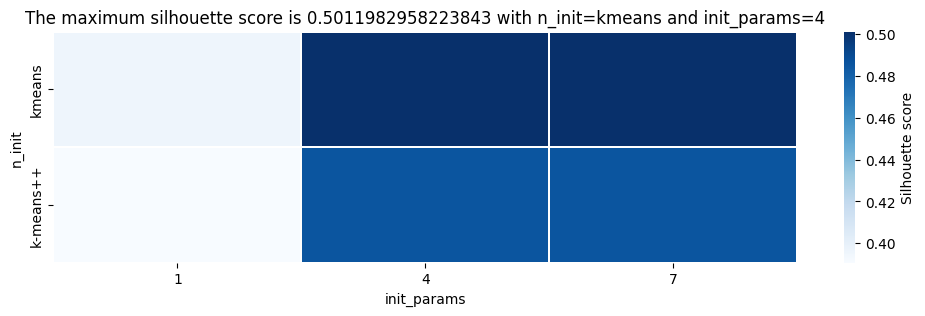

In [59]:
n_init = [1, 4, 7]
init_params = ['kmeans', 'k-means++']

sh_scores = []

for n in n_init:
    for param in init_params:
        results = GaussianMixture(n_components=17, init_params=param, random_state=42, n_init=n).fit(X)
        labels = results.predict(X)
        sh_scores.append((param, n, (silhouette_score(X, labels))))

gs = pd.DataFrame(sh_scores, columns=['n_init', 'init_params', 'sh'])
gs = pd.pivot_table(gs, columns='init_params', index='n_init', values='sh', aggfunc=lambda x:x)

plt.figure(figsize=(12,3))
max_ss = gs.max().max()
n_init_max_ss = gs.stack().idxmax()[0]
init_params_max_ss = gs.stack().idxmax()[1]
plt.title(f'The maximum silhouette score is {max_ss} with n_init={n_init_max_ss} and init_params={init_params_max_ss}')
sns.heatmap(gs, cmap='Blues', cbar_kws={'label':'Silhouette score'}, linewidths=.005)
plt.gca().invert_yaxis()
plt.show()


DBSCAN

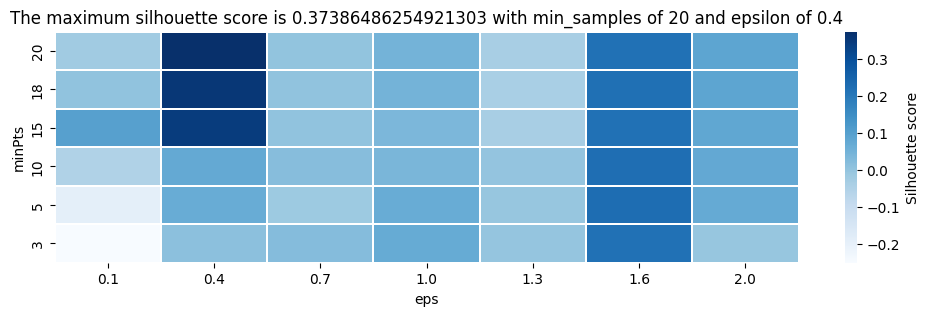

In [15]:
sh_scores =[]
mins = [3, 5, 10, 15, 18, 20]
epsilon = [0.1, 0.4, 0.7, 1, 1.3, 1.6, 2]

labels = []
for eps in epsilon:
    for min in mins:
        dbscan = DBSCAN(eps=eps, min_samples=min)
        labels = dbscan.fit_predict(X)
        sh_scores.append((eps, min, silhouette_score(X, labels)))

gs = pd.DataFrame(sh_scores, columns=['eps', 'minPts', 'sh'])
gs = pd.pivot_table(gs, columns='eps', index='minPts', values='sh', aggfunc=lambda x:x)

plt.figure(figsize=(12,3))
max_ss = gs.max().max()
mins_max_ss = gs.stack().idxmax()[0]
eps_max_ss = gs.stack().idxmax()[1]
plt.title(f'The maximum silhouette score is {max_ss} with min_samples of {mins_max_ss} and epsilon of {eps_max_ss}')
sns.heatmap(gs, cmap='Blues', cbar_kws={'label':'Silhouette score'}, linewidths=.005)
plt.gca().invert_yaxis()
plt.show()

In [64]:
labels_km = KMeans(n_clusters=13, init='k-means++', random_state=42, n_init='auto').fit_predict(X)
labels_gmm = GaussianMixture(n_components=17, random_state=42, n_init=4, init_params='kmeans').fit_predict(X)
labels_dbscan = DBSCAN(eps=0.4, min_samples=20).fit_predict(X) 

labels = [labels_km, labels_gmm, labels_dbscan]
algorithms = ['KMeans', 'GMM', 'DBSCAN']
for alg, label in zip(algorithms, labels):
    print(f'Silhouette score tuned {alg}: {silhouette_score(X, label)}')

Silhouette score tuned KMeans: 0.5424126718933323
Silhouette score tuned GMM: 0.5011982958223843
Silhouette score tuned DBSCAN: 0.3738648625492077


In [65]:
cluster_df = pd.DataFrame({'label': y, 'cid_KM':labels_km, 'cid_gmm':labels_gmm, 'cid_dbscan':labels_dbscan})

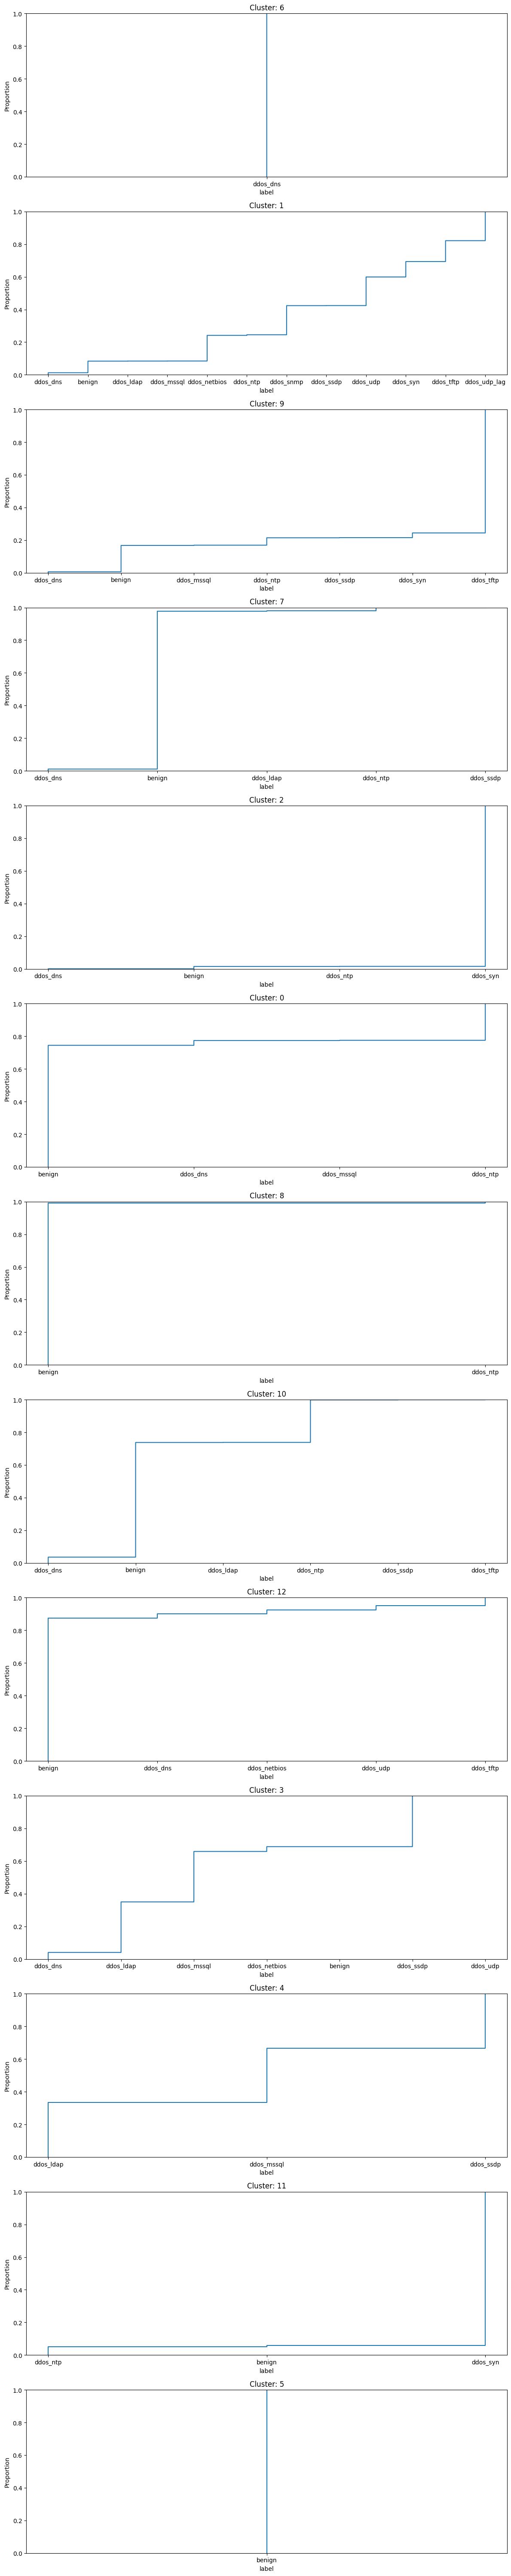

In [71]:
data = pd.DataFrame({
    'label': cluster_df['label'],
    'Cluster': cluster_df['cid_KM']
})
fig, axs = plt.subplots(len(data['Cluster'].unique()), 1, figsize=(12, 60))

for i, cluster in enumerate(data['Cluster'].unique()):
    subset = data[data['Cluster'] == cluster]
    sns.ecdfplot(subset['label'], label=f'Cluster {cluster}', ax=axs[i])
    axs[i].set_title(f'Cluster: {cluster}')
    plt.tight_layout()

plt.show()

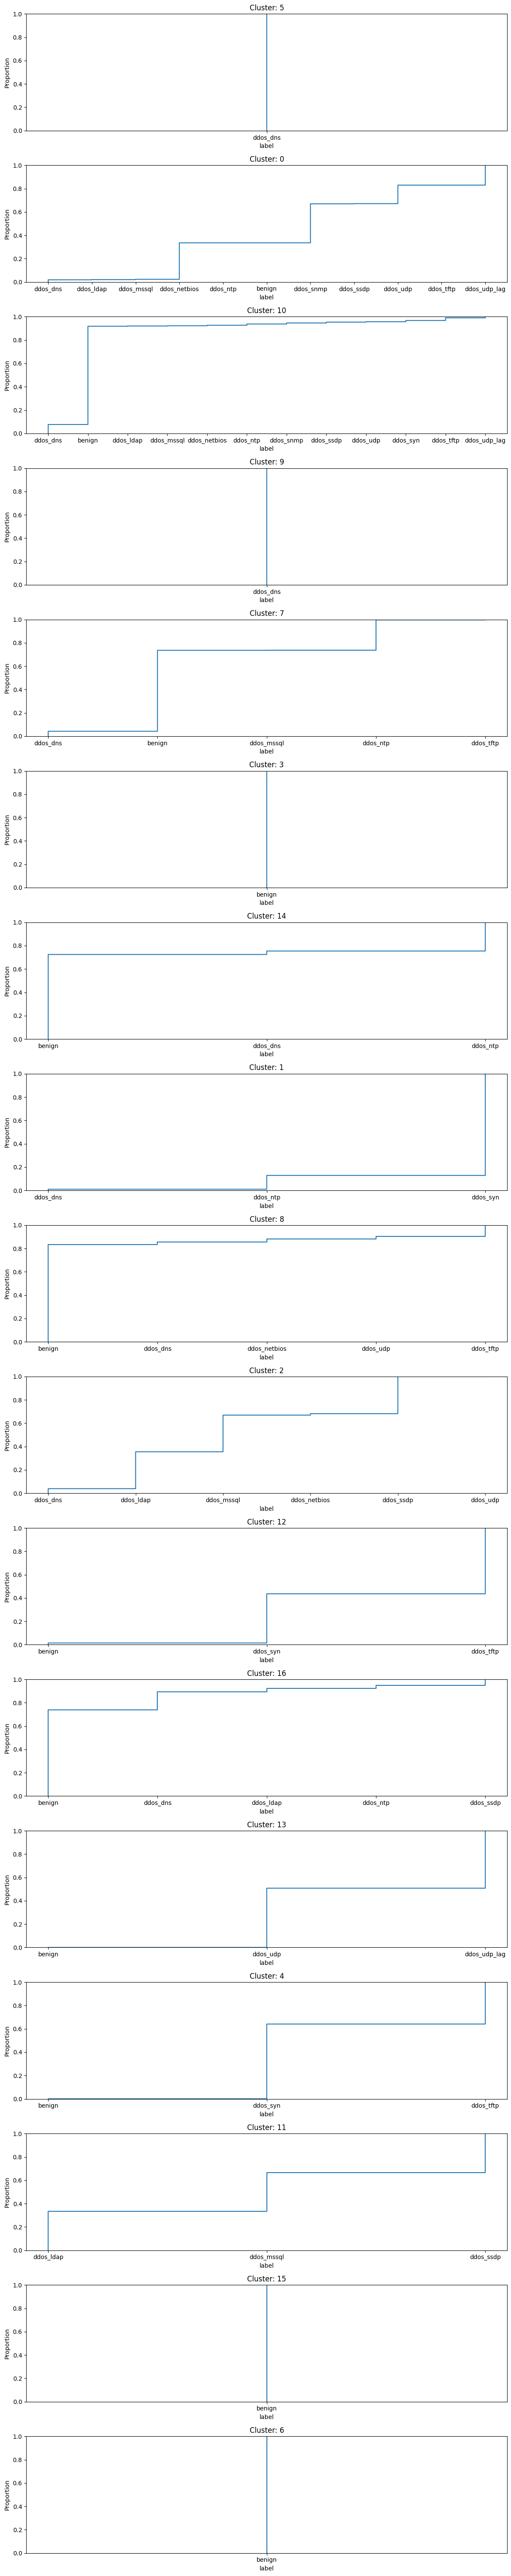

In [70]:
data = pd.DataFrame({
    'label': cluster_df['label'],
    'Cluster': cluster_df['cid_gmm']
})
fig, axs = plt.subplots(len(data['Cluster'].unique()), 1, figsize=(12, 60))

for i, cluster in enumerate(data['Cluster'].unique()):
    subset = data[data['Cluster'] == cluster]
    sns.ecdfplot(subset['label'], label=f'Cluster {cluster}', ax=axs[i])
    axs[i].set_title(f'Cluster: {cluster}')
    plt.tight_layout()

plt.show()